In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from numpy import mean
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from statsmodels.stats.outliers_influence import variance_inflation_factor

import random
import warnings
warnings.filterwarnings('ignore')

In [52]:
def convert_binary(df, columns = ['Risk1Yr']):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x == 'F' else 1)
    return df

def load_thoracic(path = '../data/ThoraricSurgery.csv'):
    data = pd.read_csv(path)
    # data = data[['PRE4', 'AGE', 'Risk1Yr']]
    data = convert_binary(data, columns = ['Risk1Yr'])
    X, y = data[['PRE4', 'AGE']], data['Risk1Yr']
    X, y = X.to_numpy(), y.to_numpy()
    y[y == 0] = -1
    return X, y

X, y = load_thoracic()

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [53]:
np.random.seed(415)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Text(0.5, 1.0, 'Imbalanced dataset')

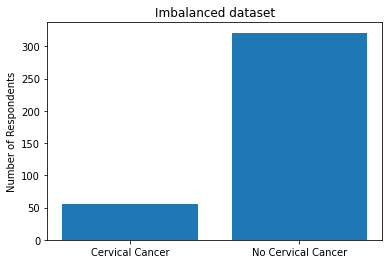

In [126]:
x = np.arange(2)
plt.bar(x, height = [len(y[y == 1]), len(y[y == 0])])
plt.xticks(x, ['Cervical Cancer', 'No Cervical Cancer'])
plt.ylabel('Number of Respondents')
plt.title('Imbalanced dataset')

In [124]:
from sklearn.tree import DecisionTreeClassifier
import random
from scipy import stats
from sklearn.metrics import classification_report

B = 5
m, n = X_train.shape
boostrap_ratio = 1
tree_params = { 'max_depth': 5, 
                'criterion':'gini', 
                'min_samples_split': 5}
                
models = [DecisionTreeClassifier(**tree_params) for _ in range(B)]

sample_size = int(boostrap_ratio * len(X_train))

xsamples = np.zeros((B, sample_size, n))
ysamples = np.zeros((B, sample_size))

for i in range(B):
    for j in range(sample_size):
        idx = random.randrange(m)  
        xsamples[i, j, :] = X_train[idx]
        ysamples[i, j] = y_train[idx]
for i, model in enumerate(models):
    _X = xsamples[i, :]
    _y = ysamples[i, :]
    model.fit(_X, _y)
predictions = np.zeros((B, X_test.shape[0]))
for i, model in enumerate(models):
    yhat = model.predict(X_test)
    predictions[i, :] = yhat
    
yhat = stats.mode(predictions)[0][0] 
print(classification_report(y_test, yhat))
print(confusion_matrix(y_test, yhat))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        64
           1       0.33      0.08      0.13        12

    accuracy                           0.83        76
   macro avg       0.59      0.53      0.52        76
weighted avg       0.77      0.83      0.78        76

[[62  2]
 [11  1]]


In [121]:
def generate_labeled(X, y, rate = 0.68, include_unlabeled = False, include_neg = False):
    random.seed(30)
    size = int(np.round(X.shape[0] * rate))
    index = random.sample(range(len(y)), size)
    labeled = random.sample([x for x in range(X.shape[0]) if x not in index], X.shape[0] - size)
    X_labeled, y_labeled = X[labeled], y[labeled]

    assert X_labeled.shape[0] == y_labeled.shape[0]

    if include_unlabeled == True:
        X_unlabel, y_unlabel = X, y.copy()
        if include_neg == True:
            y_unlabel[index] = -1
        else:
            y_unlabel[index] =  0
        return X_labeled, y_labeled, X_unlabel, y_unlabel 
    return X_labeled, y_labeled

def convert_binary(df, columns = ['Risk1Yr']):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x == 'F' else 1)
    return df

def load_thoracic(path = '../data/ThoraricSurgery.csv'):
    data = pd.read_csv(path)
    data = data[data.columns[2:]]
    data = data.drop(['PRE6', 'PRE14'], axis = 1)
    label_columns = data.columns[2:12]
    data = convert_binary(data, columns = ['Risk1Yr'])
    data = convert_binary(data, columns = label_columns)
    include_columns = data.columns[0:-1]
    X, y = data[include_columns], data['Risk1Yr']
    X, y = X.to_numpy(), y.to_numpy()
    return X, y, data

X, y, data = load_thoracic()
X, y = generate_labeled(X, y, rate = 0.20, include_neg = True)

<AxesSubplot:>

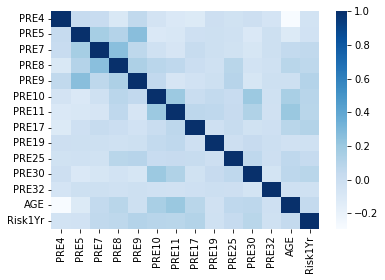

In [123]:
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), cmap = 'Blues', annot = False) 

In [111]:
def svm_train(X, y, target_names = None):
    assert X.shape[0] == y.shape[0]
    random.seed(413)
    svclassifier = SVC(kernel = 'rbf', C = 100, gamma = 1)
    svclassifier.fit(X, y)
    predictions = svclassifier.predict(X)
    print(classification_report(y, predictions, target_names = None))
    return svclassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
svclassifier = svm_train(X_train, y_train, target_names = ['No Surgery Risk', 'Surgery Risk'])

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       257
           1       0.98      0.93      0.95        43

    accuracy                           0.99       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.99      0.99      0.99       300



In [112]:
param_grid = { 
                'n_estimators': [10, 50, 100], 
                'criterion': ['gini', 'entropy'],
                'max_depth': np.arange(1, 10),
                'min_samples_split': np.arange(1, 5)
              }
model = RandomForestClassifier()

grid = GridSearchCV(model, param_grid, refit = True)
grid.fit(X_train, y_train)

print(grid.best_params_)

yhat = grid.predict(X_test)

print(classification_report(y_test, yhat))
print(confusion_matrix(y_test, yhat))

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 10}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        64
           1       0.00      0.00      0.00        12

    accuracy                           0.84        76
   macro avg       0.42      0.50      0.46        76
weighted avg       0.71      0.84      0.77        76

[[64  0]
 [12  0]]
